In [1]:
import pandas as pd
import cv2
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
from tqdm.notebook import tqdm


In [2]:
def preprocess_data(directory:str, batch_size:int, test_size:int, rand_num:int, worker:int):
    '''
        directory: the directory of processed directory with class folders inside
        batch_size: size of batch for training
        test_size: percent of dataset used for test
        rand_num: put random number for reproducibility
        worker: number of worker in computation
        
        return train and test data ready for training
    '''
    #pipeline to resize images, crop, convert to tensor, and normalize
    trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
    
    dataset = torchvision.datasets.ImageFolder(root=directory, transform=trans) #read image in folder to data with labels
    
    train_len = len(dataset) #get length of whole data
    ind = list(range(train_len)) #indices of whole data
    spl = int(np.floor(test_size * train_len)) #index of test data
    
    #reproducibility and shuffle step
    np.random.seed(rand_num) 
    np.random.shuffle(ind)
    
    #sampling preparation steps
    train_id, test_id = ind[spl:], ind[:spl]
    tr_sampl = SubsetRandomSampler(train_id)
    te_sampl = SubsetRandomSampler(test_id)

    #use data loader to get train and test set ready for training
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=tr_sampl,num_workers=worker)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=te_sampl,num_workers=worker)
    return (trainloader, testloader)

In [3]:
dire = "./Data/Processed" # directory of dataset
# loading data loader
trainloader, testloader = preprocess_data(directory=dire, batch_size=16, test_size=0.3, rand_num=40, worker=4)
# getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16_modules = list(vgg16.children())[:-1]
print(vgg16_modules)
vgg16_model = nn.Sequential(*vgg16_modules)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

In [4]:
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet_modules = list(googlenet.children())[:-1]
print(googlenet_modules)
googlenet_model = nn.Sequential(*googlenet_modules)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

[BasicConv2d(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True), BasicConv2d(
  (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True), Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 96, kerne

In [7]:

efficientnet_b7 = torchvision.models.efficientnet_b7(pretrained=True)
efficientnet_b7_modules = list(efficientnet_b7.children())[:-1]
print(efficientnet_b7_modules)
efficientnet_b7_model = nn.Sequential(*efficientnet_b7_modules)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

[Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), b

In [6]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50_modules = list(resnet50.children())[:-1]
print(resnet50_modules)
resnet50_model = nn.Sequential(*resnet50_modules)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch:[1/10], training loss: 4.1387
Epoch:[2/10], training loss: 1.1488
Epoch:[3/10], training loss: 0.6485
Epoch:[4/10], training loss: 0.3693
Epoch:[5/10], training loss: 0.2493
Epoch:[6/10], training loss: 0.1292
Epoch:[7/10], training loss: 0.1615
Epoch:[8/10], training loss: 0.1813
Epoch:[9/10], training loss: 0.1037
Epoch:[10/10], training loss: 0.0640


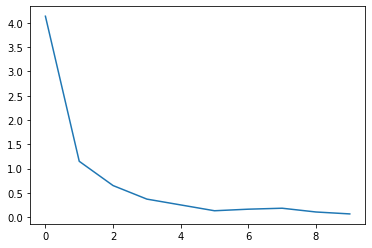

In [5]:
from ipywidgets import IntProgress
#Command out all except one of the below
#net = resnet50
#net = vgg16
#net = googlenet
net = efficientnet_b7

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net = net.to(device)
losses = []
epochs = 10
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
# YOUR CODE HERE
    Loss = 0.0
    count = 0
    for iter, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        predicted = net(images)
        _, pre1 = torch.max(predicted,dim=1)

        optimizer.zero_grad()
        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()

        Loss += loss.item() #accumulate the loss
        count += 1

    avg_loss = Loss/count
    losses.append(avg_loss) #append the average loss for each batch
    print('Epoch:[{}/{}], training loss: {:.4f}'.format(epoch+1, epochs, avg_loss))

plt.plot(losses)

In [6]:
correct = 0
total = 0

# YOUR CODE HERE
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_hat = net(images)
        max_val, max_i = torch.max(y_hat.data, 1)
        print(y_hat)
        total += labels.size(0)
        correct += (max_i == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 validation x: {100 * correct // total} %')

tensor([[11.1130, 13.2486,  7.8959,  ...,  0.6285,  0.4978,  0.1829],
        [ 6.6290,  6.8886, 13.8534,  ...,  0.7869, -0.3228, -0.2468],
        [ 5.8448, 10.7036,  4.4251,  ..., -0.7416, -0.0158, -0.6932],
        ...,
        [12.7848, 11.4652,  9.3592,  ...,  2.0233,  3.3801, -1.7275],
        [11.0994,  9.8715, 12.3424,  ...,  0.1980,  1.2951,  0.4588],
        [ 7.6077,  7.8521, 11.3472,  ..., -0.4435, -1.1069,  0.2013]])
tensor([[ 7.2603,  8.2403,  5.9583,  ...,  0.2403,  0.3742, -0.2294],
        [10.0215,  7.1358, 13.8699,  ...,  0.0294, -0.8895, -0.6518],
        [ 7.0818,  6.1212, 13.8305,  ...,  0.2304, -0.8334, -0.2420],
        ...,
        [ 7.1355,  7.3686, 15.2299,  ..., -0.1921, -0.9219,  0.1932],
        [ 8.7361, 10.5194, 10.5034,  ...,  0.4498, -1.0390,  0.8908],
        [ 8.7113, 11.2196,  7.8917,  ...,  0.0634,  1.4863,  2.5399]])
tensor([[ 8.7181e+00,  8.2301e+00,  1.2463e+01,  ..., -8.5171e-01,
         -2.3481e-02,  2.9800e-01],
        [ 8.1927e+00,  7.0919